In [1]:
import numpy as np
import h5py
import glob, os, re, sys
import pickle
from pathlib import Path
sys.path.append('../')

from GriddedData import GriddedDataset
import astro_helper as ah

import configparser
config = configparser.ConfigParser()
config.read('./config_test.ini')

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.patches as patches
from matplotlib import rc
rc('axes', linewidth=1.5)
rc('axes', edgecolor='#3C3C3C')
plt.style.use('mpl_style_Jeffreson.mplstyle')
custom_colors = {
    'grey': '#3C3C3C',
    'turquoise': '#5E9F87'
}

In [2]:
xymax = 2.
gal = GriddedDataset(
    params = config["ETG-lowM"],
    galaxy_type="ETG-lowM",
    total_height=0.3, # kpc
    zbin_width_ptl=10., # so it's quicker for checking
    xymax=xymax, # kpc
    snapname="snap-DESPOTIC_100.hdf5",
    exclude_temp_above=float(config['ETG-lowM'].get('EXCLUDE_TEMP')),
    exclude_avir_below=float(config['ETG-lowM'].get('EXCLUDE_AVIR')),
    exclude_HII=True,
    realign_galaxy_to_gas=True, # according to angular momentum vector of gas
    required_particle_types=[0,1,2,3,4], # just gas by default
)

In [3]:
# random time for each array
i = 2

In [4]:
# coolgas properties
folder = str(Path(config["ETG-lowM"]["ROOT_DIR"]) / Path(config["ETG-lowM"]["SUBDIR"]))
with open(folder+"/coolgas_399_ETG-lowM_T2.0e+04_avir2.0e+00.pkl", "rb") as f:
    coolgas_dict = pickle.load(f)
print(coolgas_dict.keys())
print([val.shape for key, val in coolgas_dict.items()])

dict_keys(['gas_surfdens', 'gas_voldens_midplane', 'star_voldens_midplane', 'veldisp_midplane', 'Pturb', 'Ptherm'])
[(50, 50, 25), (50, 50, 25), (50, 50, 25), (50, 50, 25), (50, 50, 25), (50, 50, 25)]


In [5]:
# allgas properties
folder = "/n/holystore01/LABS/itc_lab/Users/sjeffreson/ETGs/lowM-output/"
with open(folder+"allgas_399_ETG-lowM.pkl", "rb") as f:
    allgas_dict = pickle.load(f)
print(allgas_dict.keys())
print([val.shape for key, val in allgas_dict.items()])

dict_keys(['rotcurve', 'kappa', 'SFR_surfdens', 'H2_frac', 'HI_frac', 'gas_surfdens', 'star_surfdens', 'gas_voldens_midplane', 'star_voldens_midplane'])
[(50, 50, 25), (50, 50, 25), (50, 50, 25), (50, 50, 25), (50, 50, 25), (50, 50, 25), (50, 50, 25), (50, 50, 25), (50, 50, 25)]


In [9]:
# voldens properties
folder = "/n/holystore01/LABS/itc_lab/Users/sjeffreson/ETGs/lowM-output/"
with open(folder+"voldens_399_ETG-lowM.pkl", "rb") as f:
    voldens_dict = pickle.load(f)
print(voldens_dict.keys())
print([val.shape for key, val in allgas_dict.items()])

dict_keys(['gas_voldens', 'dm_voldens'])
[(50, 50, 25), (50, 50, 25), (50, 50, 25), (50, 50, 25), (50, 50, 25), (50, 50, 25), (50, 50, 25), (50, 50, 25), (50, 50, 25)]


In [10]:
# dm voldens properties
folder = "/n/holystore01/LABS/itc_lab/Users/sjeffreson/ETGs/lowM-output/"
with open(folder+"dm_voldens_399_ETG-lowM.pkl", "rb") as f:
    dm_voldens_dict = pickle.load(f)
print(dm_voldens_dict.keys())
print([val.shape for key, val in allgas_dict.items()])

dict_keys(['dm_voldens'])
[(50, 50, 25), (50, 50, 25), (50, 50, 25), (50, 50, 25), (50, 50, 25), (50, 50, 25), (50, 50, 25), (50, 50, 25), (50, 50, 25)]


In [11]:
feature_keys = ['gas_surfdens', 'star_surfdens', 'rotcurve', 'kappa', 'dm_voldens']
feature_labels = [
    r'$\log{(\Sigma_{\rm g}/{\rm M}_\odot {\rm pc}^{-2})}$',
    r'$\log{(\Sigma_{*}/{\rm M}_\odot {\rm pc}^{-2})}$',
    r'$\log{(v_{\rm circ}/{\rm km~s^{-1}})}$',
    r'$\log{(\kappa/{\rm Myr}^{-1})}$',
    r'$\log{(\rho_{\rm d}/{\rm M}_\odot {\rm pc}^{-3})}$'
]
feature_unit_conversions = [
    1./ah.Msol_to_g*ah.pc_to_cm**2,
    1./ah.Msol_to_g*ah.pc_to_cm**2,
    1./ah.kms_to_cms,
    ah.Myr_to_s,
    1./ah.Msol_to_g*ah.pc_to_cm**3
]
target_keys = ['SFR_surfdens', 'H2_surfdens', 'HI_surfdens', 'gas_voldens_midplane', 'Ptherm', 'Pturb', 'Ptot', 'veldisp_midplane']
target_labels = [
    r'$\log{(\Sigma_{\rm SFR}/{\rm M}_\odot  {\rm kpc}^{-2} {\rm yr}^{-1})}$',
    r'$\log{(\Sigma_{\rm H_2}/{\rm M}_\odot {\rm pc}^{-2})}$',
    r'$\log{(\Sigma_{\rm HI}/{\rm M}_\odot {\rm pc}^{-2})}$',
    r'$\log{(\rho_{\rm g}/{\rm M}_\odot {\rm pc}^{-3})}$',
    r'$\log{(P_{\rm th}/k_{\rm B}^{-1} {\rm K~cm}^{-3})}$',
    r'$\log{(P_{\rm turb}/k_{\rm B}^{-1} {\rm K~cm}^{-3})}$',
    r'$\log{(P_{\rm tot}/k_{\rm B}^{-1} {\rm K~cm}^{-3})}$',
    r'$\log{(\sigma_{\rm g}/{\rm km~s}^{-1})}$'
]
target_unit_conversions = [
    1./ah.Msol_to_g*ah.kpc_to_cm**2*ah.yr_to_s,
    1./ah.Msol_to_g*ah.pc_to_cm**2,
    1./ah.Msol_to_g*ah.pc_to_cm**2,
    1./ah.Msol_to_g*ah.pc_to_cm**3,
    1./ah.kB_cgs,
    1./ah.kB_cgs,
    1./ah.kB_cgs,
    1./ah.kms_to_cms
]

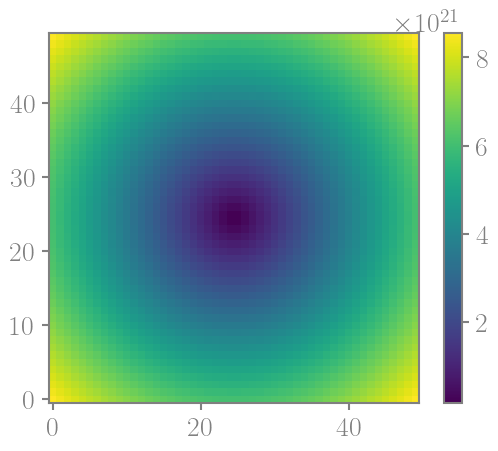

In [12]:
# generate R grid
xybinwidth = 80. # pc
xybinno = int(np.rint(2.*xymax * ah.kpc_to_cm / (xybinwidth * ah.pc_to_cm)))
x_edges = np.linspace(-xymax*ah.kpc_to_cm, xymax*ah.kpc_to_cm, xybinno+1)
y_edges = np.linspace(-xymax*ah.kpc_to_cm, xymax*ah.kpc_to_cm, xybinno+1)
x = 0.5 * (x_edges[:-1] + x_edges[1:])
y = 0.5 * (y_edges[:-1] + y_edges[1:])
xgrid, ygrid = np.meshgrid(x, y)
Rgrid = np.sqrt(xgrid**2 + ygrid**2)

plt.imshow(Rgrid, origin='lower', cmap='viridis')
cbar = plt.colorbar()
plt.show()

In [13]:
max_gas_voldens = voldens_dict['gas_voldens'][:,:,i]
allprops_dict = {
    'gas_surfdens': allgas_dict['gas_surfdens'][:,:,i],
    'star_surfdens': allgas_dict['star_surfdens'][:,:,i],
    'rotcurve': allgas_dict['rotcurve'][:,:,i],
    'kappa': allgas_dict['kappa'][:,:,i],
    'dm_voldens': dm_voldens_dict['dm_voldens'][:,:,i],
    'SFR_surfdens': allgas_dict['SFR_surfdens'][:,:,i],
    'H2_surfdens': allgas_dict['H2_frac'][:,:,i] * allgas_dict['gas_surfdens'][:,:,i],
    'HI_surfdens': allgas_dict['HI_frac'][:,:,i] * allgas_dict['gas_surfdens'][:,:,i],
    'gas_voldens_midplane': allgas_dict['gas_voldens_midplane'][:,:,i],
    'Ptherm': coolgas_dict['Ptherm'][:,:,i],
    'Pturb': coolgas_dict['Pturb'][:,:,i],
    'Ptot': coolgas_dict['Pturb'][:,:,i] + coolgas_dict['Ptherm'][:,:,i],
    'veldisp_midplane': coolgas_dict['veldisp_midplane'][:,:,i]
}

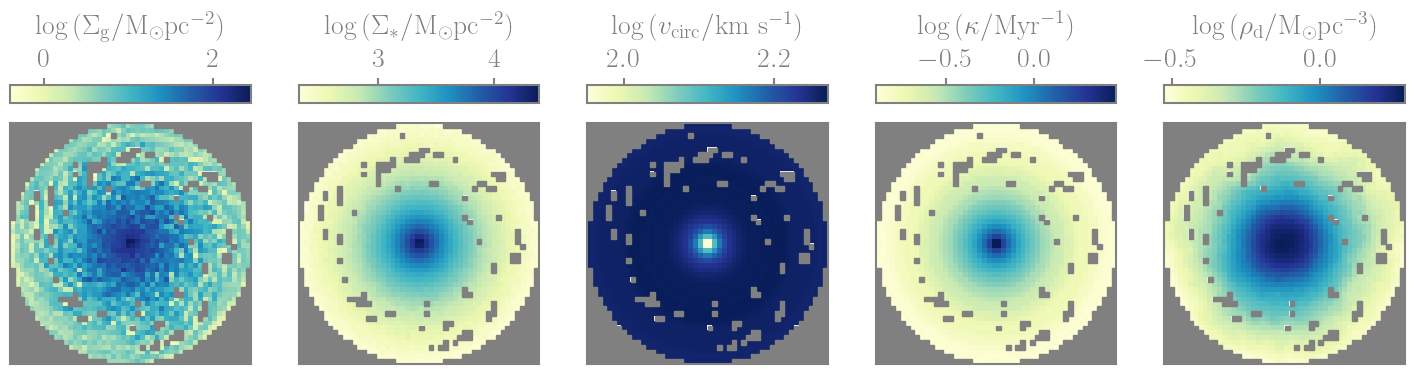

In [14]:
# row of 5 panels for features, with colorbars above
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, axs = plt.subplots(1, 5, figsize=(18, 4))
for i, key in enumerate(feature_keys):
    ax = axs[i]
    cnd = np.where(max_gas_voldens/ah.mp_cgs/ah.mu < 0.13)
    img_restricted = allprops_dict[key].copy()
    img_restricted[np.isnan(img_restricted)] = 0
    img_restricted[Rgrid > xymax*ah.kpc_to_cm] = np.nan
    img_restricted[cnd] = np.nan
    cax = ax.imshow(np.log10(img_restricted*feature_unit_conversions[i]), cmap='YlGnBu')

    # red outline around nan values
    for j in range(0, img_restricted.shape[0]):
        for k in range(0, img_restricted.shape[1]):
            if np.isnan(img_restricted[j,k]):
                rect = patches.Rectangle((k-0.5, j-0.5), 1, 1, linewidth=1, edgecolor='grey', facecolor='grey')
                ax.add_patch(rect)

    divider = make_axes_locatable(ax)
    cax_top = divider.append_axes("top", size="7.5%", pad=0.2)
    cbar = fig.colorbar(cax, cax=cax_top, orientation='horizontal')
    cax_top.xaxis.set_ticks_position('top')
    cax_top.xaxis.set_label_position('top')
    cbar.set_label(feature_labels[i])

    ax.set_xticks([])
    ax.set_yticks([])

plt.savefig(
    '/n/holystore01/LABS/itc_lab/Users/sjeffreson/GalactISM/figs/dataset_features.pdf',
    bbox_inches='tight',
    format='pdf'
)
plt.show()


/tmp/ipykernel_2263255/332843906.py:25: RuntimeWarning: divide by zero encountered in log10
  cax = ax.imshow(np.log10(img_restricted * target_unit_conversions[i]),
/tmp/ipykernel_2263255/332843906.py:22: RuntimeWarning: divide by zero encountered in log10
  cax = ax.imshow(np.log10(img_restricted * target_unit_conversions[i]),
/tmp/ipykernel_2263255/332843906.py:28: RuntimeWarning: divide by zero encountered in log10
  cax = ax.imshow(np.log10(img_restricted * target_unit_conversions[i]),


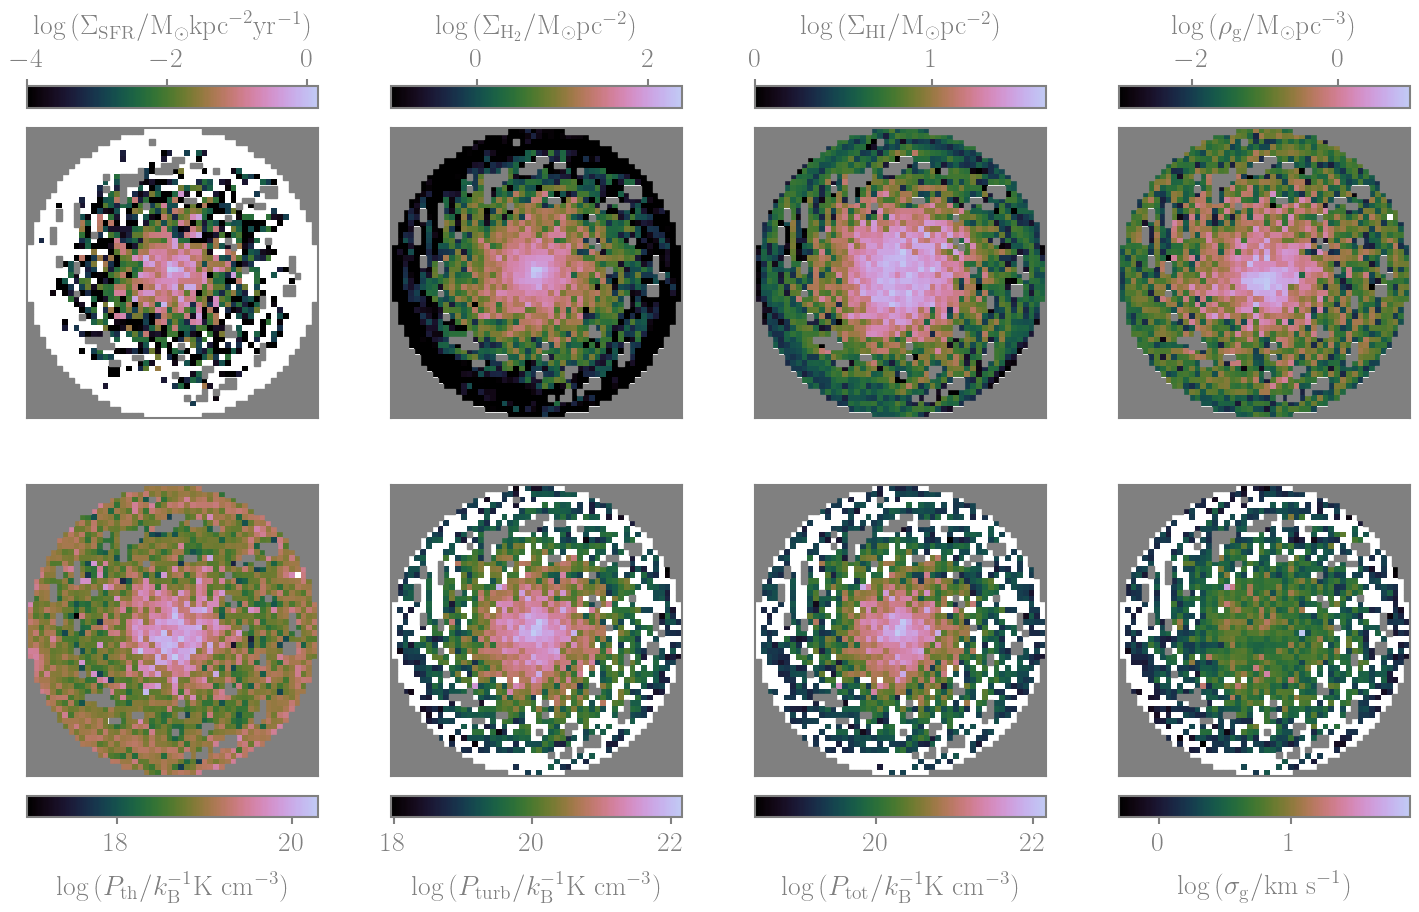

In [35]:
# truncate the cubehelix colormap
cmap = cm.cubehelix
cmap_trunc = mpl.colors.LinearSegmentedColormap.from_list(
    'cubehelix_trunc', cmap(np.linspace(0., 0.8, 256)))

# two rows of four panels for the targets, with colorbars above and below
fig, axs = plt.subplots(2, 4, figsize=(18, 9.5))
for i, key in enumerate(target_keys):
    ax = axs[i//4, i%4]
    cnd = np.where(max_gas_voldens/ah.mp_cgs/ah.mu < 0.13)
    img_restricted = allprops_dict[key].copy()
    img_restricted[np.isnan(img_restricted)] = 0
    img_restricted[Rgrid > xymax*ah.kpc_to_cm] = np.nan
    img_restricted[cnd] = np.nan
    if key=='H2_surfdens':
        cax = ax.imshow(np.log10(img_restricted * target_unit_conversions[i]),
                        cmap=cmap_trunc, vmin=-1.)
    elif key=='HI_surfdens':
        cax = ax.imshow(np.log10(img_restricted * target_unit_conversions[i]),
                        cmap=cmap_trunc, vmin=0.)
    elif key=='gas_voldens_midplane':
        cax = ax.imshow(np.log10(img_restricted * target_unit_conversions[i]),
                        cmap=cmap_trunc, vmin=-3.)
    elif key=='SFR_surfdens':
        cax = ax.imshow(np.log10(img_restricted * target_unit_conversions[i]),
                        cmap=cmap_trunc, vmin=-4.)
    else:
        cax = ax.imshow(np.log10(img_restricted * target_unit_conversions[i]),
                        cmap=cmap_trunc)

    # red outline around nan values
    for j in range(0, img_restricted.shape[0]):
        for k in range(0, img_restricted.shape[1]):
            if np.isnan(img_restricted[j,k]):
                rect = patches.Rectangle((k-0.5, j-0.5), 1, 1, linewidth=1, edgecolor='grey', facecolor='grey')
                ax.add_patch(rect)

    divider = make_axes_locatable(ax)

    if i < 4:
        cax_top = divider.append_axes("top", size="7.5%", pad=0.2)
        cbar = fig.colorbar(cax, cax=cax_top, orientation='horizontal')
        cax_top.xaxis.set_ticks_position('top')
        cax_top.xaxis.set_label_position('top')
    else:
        cax_bot = divider.append_axes("bottom", size="7.5%", pad=0.2)
        cbar = fig.colorbar(cax, cax=cax_bot, orientation='horizontal')
        cax_bot.xaxis.set_ticks_position('bottom')
        cax_bot.xaxis.set_label_position('bottom')
    cbar.set_label(target_labels[i])

    ax.set_xticks([])
    ax.set_yticks([])

plt.savefig(
    '/n/holystore01/LABS/itc_lab/Users/sjeffreson/GalactISM/figs/dataset_targets.pdf',
    bbox_inches='tight',
    format='pdf'
)
plt.show()